In [ ]:
# PAN vs NOR binary classification

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import omicverse as ov
import math
import warnings
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, auc
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
print("正在运行在：", os.uname())


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/omicverse/utils/_data.py:329: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


正在运行在： posix.uname_result(sysname='Linux', nodename='mirnalab-Super-Server', release='6.8.0-59-generic', version='#61~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 15 17:03:15 UTC 2', machine='x86_64')


In [ ]:
# read data
file_path = Path(r'/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_selected_Masslin2_0801.csv')
data = pd.read_csv(file_path, index_col=0)


(476, 398)
             CandidatusAtelocyanobacterium  Herminiimonas  Paralcaligenes  \
BRC_NXYK_1                               0              4               0   
BRC_NXYK_10                             14              2               2   
BRC_NXYK_11                             10              0               0   
BRC_NXYK_12                              0              2               0   
BRC_NXYK_13                             42              1               0   

             Wielerella  Syntrophothermus  Conchiformibius  \
BRC_NXYK_1            0                 0                0   
BRC_NXYK_10           0                 0                0   
BRC_NXYK_11           0                 0                0   
BRC_NXYK_12           2                 1                2   
BRC_NXYK_13           0                 1                0   

             CandidatusNucleicultrix  Sideroxyarcus  Deefgea  \
BRC_NXYK_1                         5              6        1   
BRC_NXYK_10              

In [ ]:
Y= data['group'].to_numpy()
X= data.drop(['group'], axis=1).to_numpy()
X = StandardScaler().fit_transform(X)

In [ ]:
# define a MLRes class to save result
class MLRes:
    def __init__(self, seed, clf, auc, tpr, fpr, clf_type, target_class, precision, recall, aupr, f1score):
        self.seed = seed
        self.clf = clf
        self.auc = auc
        self.tpr = tpr
        self.fpr = fpr
        self.clf_type = clf_type
        self.target_class = target_class
        self.precision = precision
        self.recall = recall
        self.aupr = aupr
        self.f1score = f1score

train_results=[]

# normalized the data 
X = StandardScaler().fit_transform(data.drop(['group'], axis=1))


# generate the binary label function
def generate_labels(data, target_class):
    return np.array([target_class if i == target_class else 'PAN' for i in data['group']])

# Define a general classifier training and evaluation function
def train_and_evaluate_classifier(X, Y, classifier, tuned_parameters, seed,target_class):
    # split the train and test set 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)
    # oversampling by SMOTE
    sm = SMOTE(random_state=seed)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    # GridSearchCV
    clf = GridSearchCV(classifier, tuned_parameters, cv=10, scoring="accuracy", n_jobs=60, verbose=0)
    clf.fit(X_train, y_train)
    # Trans y-test label to binary classification label
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    # obatin the predict pro
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    # F1 score accuracy recall
    y_pred = clf.predict(X_test)
    y_pred_binarized = np.array([1 if pred == target_class else 0 for pred in y_pred])
    precision = precision_score(y_test_binarized, y_pred_binarized)
    recall = recall_score(y_test_binarized, y_pred_binarized)
    f1score = f1_score(y_test_binarized, y_pred_binarized)

    # AUPR
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_binarized, y_pred_prob)
    aupr = auc(recall_curve, precision_curve)
    return MLRes(seed, clf, roc_auc, tpr, fpr, type(classifier).__name__, target_class, precision, recall, aupr, f1score)

# Parameter adjustment network
seed = 0
classifiers_and_params = {
    MLPClassifier(random_state=seed, max_iter=2500000): {
        'hidden_layer_sizes': [(5,), (5,2), (5,5,2)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['lbfgs', 'sgd', 'adam'], 
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    KNeighborsClassifier(): {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    RandomForestClassifier(random_state=seed): {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    GradientBoostingClassifier(random_state=seed): {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    SVC(probability=True, random_state=seed): {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
}




In [ ]:

for target_class in ['NOR']:
    Y = generate_labels(data, target_class)
    for seed in [52, 520, 2500, 5000, 10000, 10, 24, 240, 2000,3000]:
        print(f'Seed = {seed}, Target Class = {target_class}')
        for classifier, params in classifiers_and_params.items():
            result = train_and_evaluate_classifier(X, Y, classifier, params, seed)
            train_results.append(result)

# write to file
with open('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_binary_CA_PAN VS NOR.txt', 'w') as f:
    f.write(f'Clf_type\tSeed\tTargetClass\tAUROC\tPricision\tRecall\tAUPR\tF1Score\n')

for res in train_results:
    print(f'Classifier: {res.clf_type}, Seed: {res.seed}, Target Class: {res.target_class}, AUC: {res.auc}, Precision: {res.precision}, Recall: {res.recall}, AUPR: {res.aupr}, F1 Score: {res.f1score}')
    with open('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_binary_CA_PAN VS NOR.txt', 'a') as f:
        f.write(f'{res.clf_type}\t{res.seed}\t{res.target_class}\t{res.auc}\t{res.precision}\t{res.recall}\t{res.aupr}\t{res.f1score}\n')

joblib.dump(train_results, '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_binary_CA_PAN_VS_NOR.pkl')

Seed = 52, Target Class = NOR
Seed = 520, Target Class = NOR
Seed = 2500, Target Class = NOR


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed 

Seed = 5000, Target Class = NOR
Seed = 10000, Target Class = NOR


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed 

Seed = 10, Target Class = NOR
Seed = 24, Target Class = NOR
Seed = 240, Target Class = NOR
Seed = 2000, Target Class = NOR
Seed = 3000, Target Class = NOR
Classifier: MLPClassifier, Seed: 52, Target Class: NOR, AUC: 0.7826923076923077, Precision: 0.39285714285714285, Recall: 0.1375, AUPR: 0.8755792952224852, F1 Score: 0.2037037037037037
Classifier: KNeighborsClassifier, Seed: 52, Target Class: NOR, AUC: 0.7270833333333333, Precision: 0.5822784810126582, Recall: 0.575, AUPR: 0.8586475840336134, F1 Score: 0.5786163522012578
Classifier: RandomForestClassifier, Seed: 52, Target Class: NOR, AUC: 0.9022435897435896, Precision: 0.09090909090909091, Recall: 0.025, AUPR: 0.9451942335922672, F1 Score: 0.0392156862745098
Classifier: GradientBoostingClassifier, Seed: 52, Target Class: NOR, AUC: 0.8233974358974359, Precision: 0.2962962962962963, Recall: 0.1, AUPR: 0.8899414760808142, F1 Score: 0.14953271028037382
Classifier: SVC, Seed: 52, Target Class: NOR, AUC: 0.7858974358974359, Precision: 0.33

['/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_binary_CA_PAN_VS_NOR.pkl']

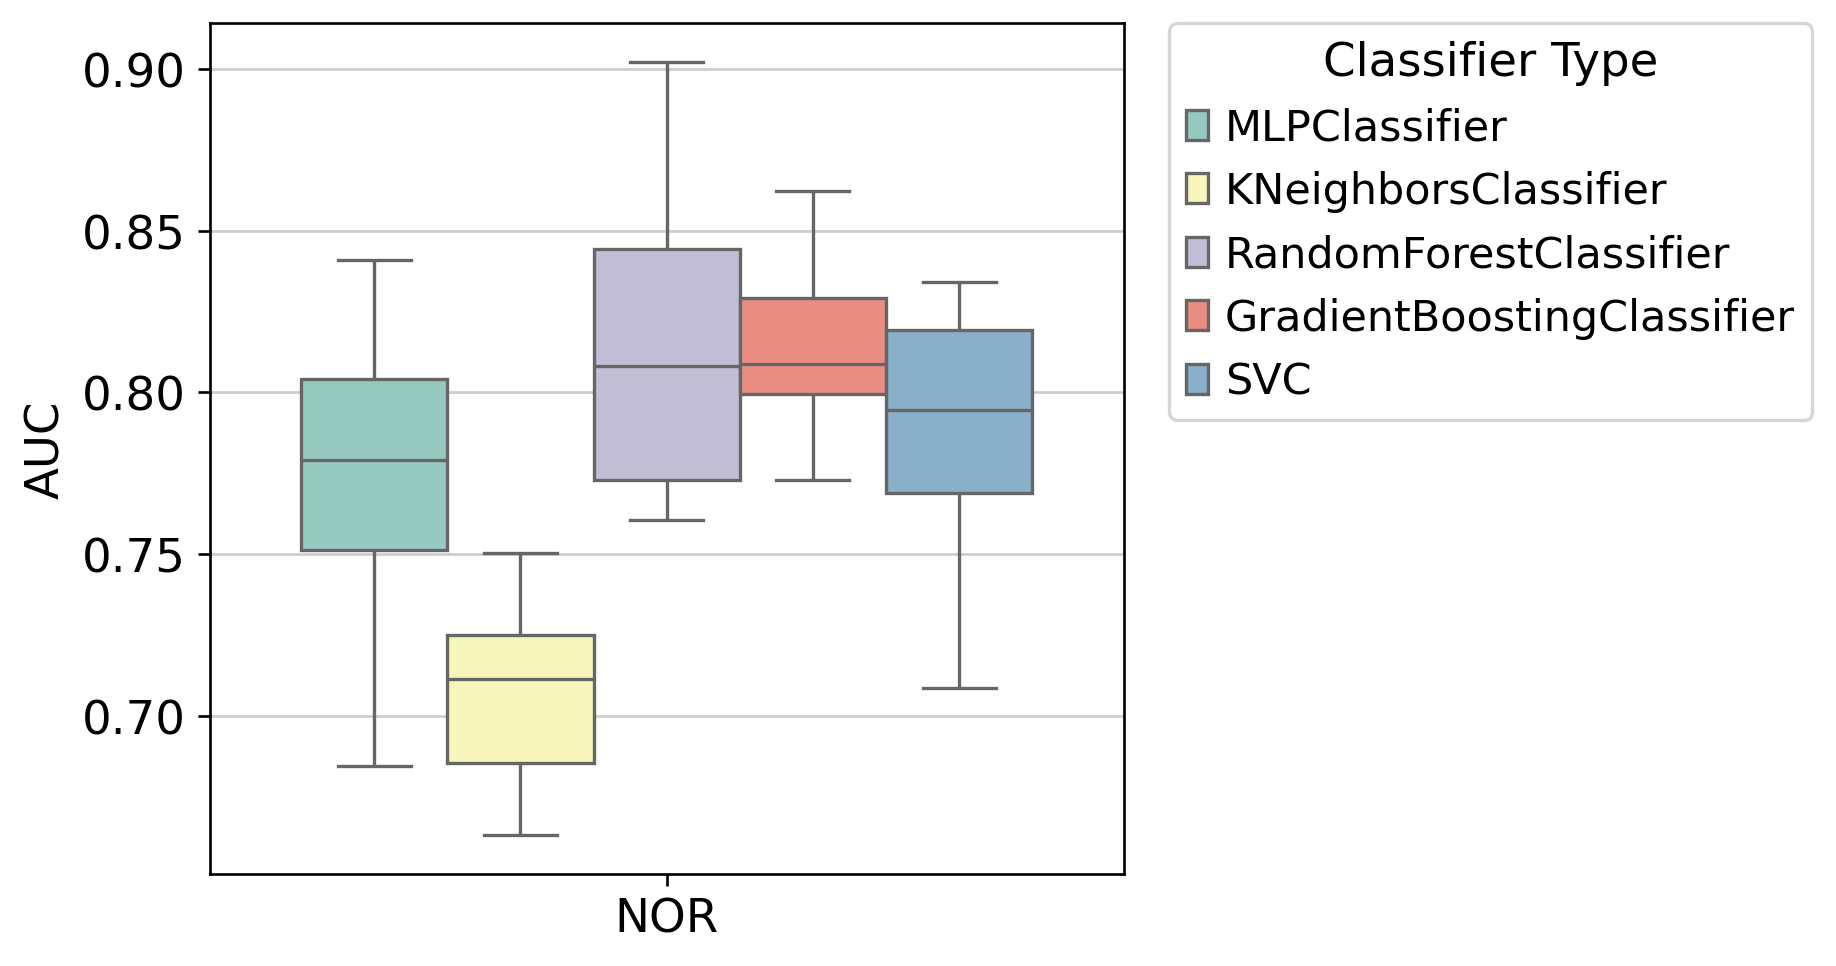

In [ ]:
# reading the train data
import pickle
import matplotlib as mpl
file = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_binary_CA_PAN_VS_NOR.pkl'
train_results = joblib.load(file)


# Draw the box plot
# Create an empty dictionary to store data
data = {'seed': [], 'clf': [], 'auc': [], 'tpr': [], 'fpr': [], 'clf_type': [], 'target_class': [], 'precision': [], 'recall': [], 'aupr': [], 'f1score': []}
for res in train_results:
    data['seed'].append(res.seed)
    data['clf'].append(res.clf)
    data['auc'].append(res.auc)
    data['tpr'].append(res.tpr)
    data['fpr'].append(res.fpr)
    data['clf_type'].append(res.clf_type)
    data['target_class'].append(res.target_class)
    data['precision'].append(res.precision)
    data['recall'].append(res.recall)
    data['aupr'].append(res.aupr)
    data['f1score'].append(res.f1score)

df = pd.DataFrame(data)
#df
mpl.rcParams['pdf.fonttype'] = 42  
mpl.rcParams['ps.fonttype']  = 42 
mpl.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=(8, 4.5))
ax = sns.boxplot(x="target_class", y="auc", hue="clf_type", data=df, palette="Set3").legend(title="Classifier Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Move the legend outside of the plot and arrange it vertically
plt.legend(title="Classifier Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
# Apply tight_layout to the whole figure, not the legend
plt.tight_layout()
plt.xlabel('')
plt.ylabel('AUC')
plt.savefig(f'/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_binary_AUCboxplot.pdf')

✅ Global: Best threshold = 0.533, Macro-F1 = 0.725


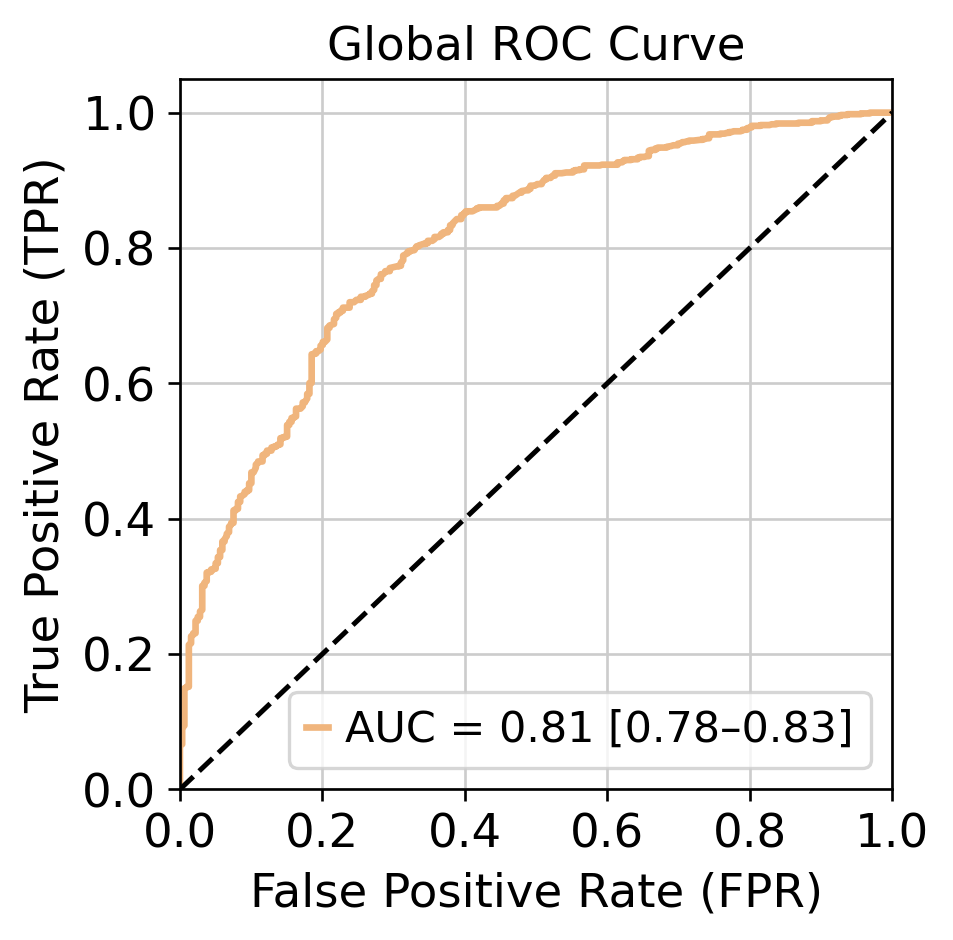

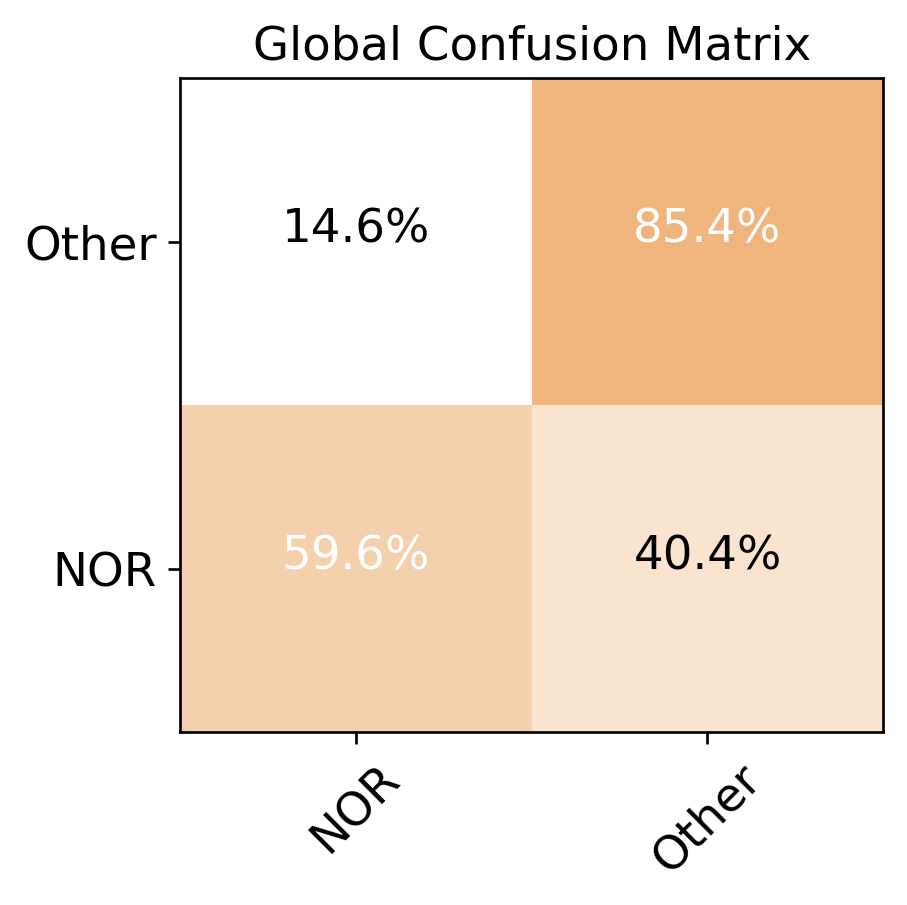

In [ ]:
# Fixed model, combined results of all seeds
# ROC curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# loading the data
file_path = Path('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_selected_Masslin2_0801.csv')
data = pd.read_csv(file_path, index_col=0)

# extract the feature and label
Y = ['NOR' if i == 'NOR' else 'Other' for i in data['group']]
X = data.drop(['group'], axis=1).to_numpy()
X = StandardScaler().fit_transform(X)

# initialization
all_probs = []
all_y_true_bin = []
all_y_true_label = []

# Fixed the target_class and models
target_class = 'NOR'
clf_type = 'RandomForestClassifier'
seed_list = df[(df['target_class'] == target_class) & (df['clf_type'] == clf_type)]['seed'].unique()

for seed in seed_list:
    try:
        clf_row = df[(df['target_class'] == target_class) & 
                     (df['seed'] == seed) & 
                     (df['clf_type'] == clf_type)]

        if clf_row.empty:
            print(f"Seed {seed} 无模型，跳过")
            continue

        clfs = clf_row['clf'].reset_index(drop=True)

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)
        y_true_bin = np.array([1 if y == 'Other' else 0 for y in y_test])

        pred_probs = []
        for clf in clfs:
            prob = clf.predict_proba(X_test)[:, 1]
            pred_probs.append(prob)
        avg_pred_prob = np.mean(pred_probs, axis=0)

        all_probs.extend(avg_pred_prob)
        all_y_true_bin.extend(y_true_bin)
        all_y_true_label.extend(y_test)

    except Exception as e:
        print(f"❌ Seed {seed} 出现错误：{e}")

fpr, tpr, _ = roc_curve(all_y_true_bin, all_probs)
roc_auc = auc(fpr, tpr)

from sklearn.utils import resample
n_bootstraps = 1000
rng_seed = 42
bootstrapped_scores = []
y_true_arr = np.array(all_y_true_bin)
y_prob_arr = np.array(all_probs)
n_samples = len(y_true_arr)
# bootstrap for 95 CI
for i in range(n_bootstraps):
    idx = resample(np.arange(n_samples), replace=True, random_state=rng_seed + i)
    if len(np.unique(y_true_arr[idx])) < 2:
        continue
    score = auc(*roc_curve(y_true_arr[idx], y_prob_arr[idx])[:2])
    bootstrapped_scores.append(score)

ci_lower = np.percentile(bootstrapped_scores, 2.5)
ci_upper = np.percentile(bootstrapped_scores, 97.5)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
plt.figure()
plt.plot(fpr, tpr,
         label=f'AUC = {roc_auc:.2f} [{ci_lower:.2f}–{ci_upper:.2f}]',
         linewidth=2, color='#F0b57D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Global ROC Curve')
plt.legend(loc="lower right")
plt.gca().set_aspect(.95)
plt.gcf().set_size_inches(4.15, 4.15)
plt.tight_layout()
plt.savefig('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_Binary_ROC.pdf')

# best thresholds and confuse matrix
thresholds = np.linspace(0.0, 1.0, 200)
macro_f1_scores = []
for thresh in thresholds:
    y_pred_bin = (np.array(all_probs) >= thresh).astype(int)
    f1_macro = f1_score(all_y_true_bin, y_pred_bin, average='macro')
    macro_f1_scores.append(f1_macro)

best_idx = np.argmax(macro_f1_scores)
best_threshold = thresholds[best_idx]
print(f"✅ Global: Best threshold = {best_threshold:.3f}, Macro-F1 = {macro_f1_scores[best_idx]:.3f}")

y_pred_final = (np.array(all_probs) >= best_threshold).astype(int)
y_pred_labels = np.where(y_pred_final == 1, 'Other', 'NOR')

cm = confusion_matrix(all_y_true_label, y_pred_labels, labels=['NOR', 'Other'])
classes = ['NOR', 'Other']
tick_marks = np.arange(len(classes))
row_sums = cm.sum(axis=1, keepdims=True)
cm_percent = cm / row_sums * 100
thresh_cm = cm_percent.max() / 2.

cmap = LinearSegmentedColormap.from_list('custom orange',
                                          ['#FFFFFF', '#F0b57D'], N=256)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(cm_percent,
                     cmap=cmap,
                     edgecolors='none',
                     shading='nearest')

ax.set_title('Global Confusion Matrix')
ax.set_xticks(tick_marks); ax.set_xticklabels(classes, rotation=45)
ax.set_yticks(tick_marks); ax.set_yticklabels(classes)
ax.grid(False)

th = thresh_cm
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i,
            f'{cm_percent[i,j]:.1f}%',
            ha='center',
            color='white' if cm_percent[i,j] > th else 'black')

plt.tight_layout()

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
plt.savefig('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_Binary_cm.pdf')




In [ ]:
# Summary model performance

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc as sk_auc,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    roc_curve
)
from sklearn.utils import resample

target_class   = 'NOR'
n_bootstraps   = 1000
rng_seed       = 42
n_thresh       = 200

# intialization
per_seed_records = []
agg = {m: {'probs': [], 'truth': []} for m in df['clf_type'].unique()}

for clf_type in df['clf_type'].unique():
    seed_list = df[
        (df['target_class']==target_class) &
        (df['clf_type']==clf_type)
    ]['seed'].unique()
    for seed in seed_list:
        df_sub = df[
            (df['target_class']==target_class)&
            (df['clf_type']==clf_type)&
            (df['seed']==seed)
        ]
        if df_sub.empty:
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.25, random_state=seed
        )
        y_true_bin = np.array([1 if y=='Other' else 0 for y in y_test])

        # 3) soft‐vote 
        probs = [row['clf'].predict_proba(X_test)[:,1] for _, row in df_sub.iterrows()]
        avg_prob = np.mean(probs, axis=0)

        agg[clf_type]['probs'].extend(avg_prob)
        agg[clf_type]['truth'].extend(y_true_bin.tolist())

        seed_auc   = roc_auc_score(y_true_bin, avg_prob)
        pr, rc, _  = precision_recall_curve(y_true_bin, avg_prob)
        seed_aupr  = sk_auc(rc, pr)
        # best thresholds
        ths = np.linspace(0,1,n_thresh)
        f1s = [f1_score(y_true_bin, (avg_prob>=t).astype(int), average='macro') for t in ths]
        best_t = ths[np.argmax(f1s)]
        y_pred = (avg_prob>=best_t).astype(int)
        tn = np.sum((y_true_bin==0)&(y_pred==0))
        fp = np.sum((y_true_bin==0)&(y_pred==1))
        sens = recall_score(y_true_bin, y_pred, zero_division=0)
        spec = tn/(tn+fp) if (tn+fp)>0 else np.nan
        prec = precision_score(y_true_bin, y_pred, zero_division=0)
        rec  = sens
        f1   = f1_score(y_true_bin, y_pred)
        youd = sens + spec - 1
        acc  = accuracy_score(y_true_bin, y_pred)

        per_seed_records.append({
            'model':        clf_type,
            'seed':         seed,
            'AUC':          seed_auc,
            'AUPR':         seed_aupr,
            'F1':           f1,
            'threshold':    best_t,
            'youden_index': youd,
            'precision':    prec,
            'sensitivity':  sens,
            'specificity':  spec,
            'recall':       rec,
            'accuracy':     acc
        })

# 6) output
df_seed = pd.DataFrame(per_seed_records)

# 7) calculate mean and 95 CI
model_summaries = []
for clf_type, data_dict in agg.items():
    probs = np.array(data_dict['probs'])
    truths= np.array(data_dict['truth'])
    fpr, tpr, _ = roc_curve(truths, probs)
    mean_auc    = auc(fpr, tpr)
    # CI bootstrap
    bs = []
    n_s = len(truths)
    for i in range(n_bootstraps):
        idx = resample(np.arange(n_s), replace=True, random_state=rng_seed+i)
        if len(np.unique(truths[idx]))<2: continue
        fpr_b, tpr_b, _ = roc_curve(truths[idx], probs[idx])
        sc = auc(fpr_b, tpr_b)
        bs.append(max(sc,1-sc))
    ci_lo = np.percentile(bs,2.5)
    ci_hi = np.percentile(bs,97.5)
    # mean of other metrics from df_seed
    df_m = df_seed[df_seed['model']==clf_type]
    mean_row = df_m.drop(columns=['seed']).mean(numeric_only=True).to_dict()
    # override AUC and add CI
    mean_row['AUC']            = mean_auc
    mean_row['AUC_CI_lower']   = ci_lo
    mean_row['AUC_CI_upper']   = ci_hi
    mean_row['seed']           = 'mean'
    mean_row['model']          = clf_type
    model_summaries.append(mean_row)

# final output
df_mean = pd.DataFrame(model_summaries)
df_all_models = pd.concat([df_seed, df_mean], ignore_index=True)
df_all_models.to_csv('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_binary_summary.csv',
                     index=False, encoding='utf-8')

print("Saved all_models_per_seed_metrics.csv and all_models_per_seed_and_mean_metrics.csv")


Saved all_models_per_seed_metrics.csv and all_models_per_seed_and_mean_metrics.csv
